In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Read in data. The first column (column 0) is the index in this dataset.

In [41]:
cust_data = pd.read_csv("datasets\\anon_cust_data.csv", index_col=[0])

Using the info method from pandas to check datatypes and see if any of the columns
have a different non-null count that the others.

In [204]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Split the target and features into different variables. Variables given the prefix orig because they will be copied in the next line to avoid accidentally modifying the original data. A full copy may not be advised in very-large datasets.

The target varaiables is "Churn", which is in the last column. All other columns are features.

In [285]:
y_orig = cust_data["Churn"]
X_orig = cust_data.iloc[:, 0:-1]
X_orig.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15


X and y are copies of the original data.

In [300]:
y = y_orig.copy()
X = X_orig.copy()

The data is split into training, testing, and validation sets. In this case the data is split 60/40 then that 40 is split in half. This leaves us with a final split of:
1. 60% training
2. 20% testing
3. 20% validation

The shapes of each group is then printed to ensure that the splits have the right number of observations in each set.

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=99)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=99)
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7043, 19)
(4225, 19)
(1409, 19)
(1409, 19)


Code to change the "TotalCharges" column into a number from an 'object' type as seen above.

In [ ]:
X_train["TotalCharges"] = pd.to_numeric(X_train["TotalCharges"], errors='coerce')
X_train["TotalCharges"].fillna(value=X_train['TotalCharges'].mean(), inplace=True)

Creates a separate target variable that has transformed all "Yes" observations to 1 and all "No" observations to 0. This can also be accomplished with sklearn's LabelBinarizer or OneHotEncoder.

In [ ]:
y_train2 = y_train.mask(cond=(y_train == "Yes"), other=1,)
y_train2.mask(cond=(y_train == "No"), other=0, inplace=True)

y_test2 = y_test.mask(cond=(y_test == "Yes"), other=1,)
y_test2.mask(cond=(y_test == "No"), other=0, inplace=True)

In [302]:
cat_feature_list = X_train.select_dtypes(include='object').columns.tolist()
num_feature_list = X_train.select_dtypes(exclude='object').columns.tolist() 


cat_transformer = Pipeline(
    steps=[('oh_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))]
)

num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_feature_list),
        ("num", num_transformer, num_feature_list)
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(C=1000, max_iter=1000))]
)

rand_for = Pipeline(
    steps=[("preprocessor", preprocessor), ("rand_forest", RandomForestClassifier(n_estimators=10000, random_state=99))]
)

3786    0
2539    0
3381    0
224     0
6048    1
       ..
1768    0
1737    0
3240    1
5305    0
4737    0
Name: Churn, Length: 4225, dtype: object


In [303]:
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


0.8099408284023669
0.7977288857345636


In [290]:
rand_for.fit(X_train, y_train)
print(rand_for.score(X_train, y_train))
print(rand_for.score(X_test, y_test))

0.9988165680473373
0.7856635911994322


In [304]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
import statsmodels as sm

c:\Users\Chad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


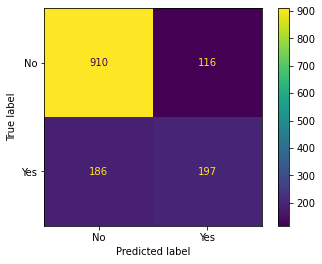

In [292]:
rand_for_predicted = rand_for.predict(X_test)
conf_matrix = confusion_matrix(y_test, rand_for_predicted)
disp_conf_matrix = plot_confusion_matrix(rand_for, X_test, y_test)

19 30


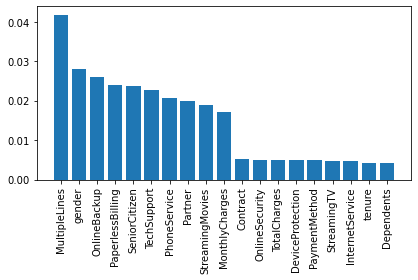

In [293]:
feature_names = X_train.columns.to_list()
#feature_names = pd.Series(cat_transformer.get_feature_names())
coefs = pd.Series(rand_for.named_steps['rand_forest'].feature_importances_)

print(len(feature_names), len(coefs))

zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])

#coefs.nlargest(200).plot(kind='barh')

sorted_df = df.sort_values('value', axis=0, ascending=False)

plt.bar(sorted_df["feature"], sorted_df["value"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



c:\Users\Chad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


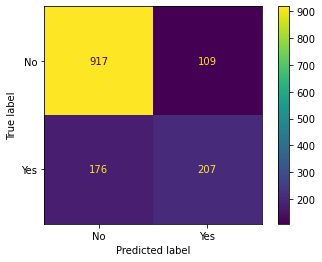

In [305]:
clf_predicted = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, clf_predicted)
disp_conf_matrix = plot_confusion_matrix(clf, X_test, y_test)

In [295]:
class_report = classification_report(y_test, clf_predicted)
print(class_report)


              precision    recall  f1-score   support

          No       0.73      1.00      0.84      1026
         Yes       0.00      0.00      0.00       383

    accuracy                           0.73      1409
   macro avg       0.36      0.50      0.42      1409
weighted avg       0.53      0.73      0.61      1409



c:\Users\Chad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Chad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [306]:
clf_proba = clf.predict_log_proba(X_test)
clf_predictions = clf_proba[:, 1]

# rand_for_proba = rand_for.predict_log_proba(X_test)
# rand_for_predictions = rand_for_proba[:, 1]

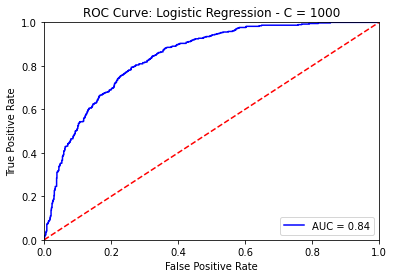

In [307]:
fpr, tpr, threshold = roc_curve(y_test, clf_predictions, pos_label="Yes")
roc_auc = auc(fpr, tpr)


plt.title('ROC Curve: Logistic Regression - C = 1000')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

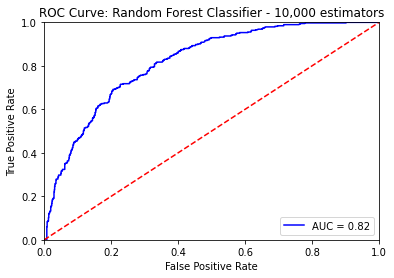

In [298]:
rand_for_predictions[np.isneginf(rand_for_predictions)] = 0.01
np.nan_to_num(rand_for_predictions, copy=True, neginf=0)
# print(rand_for_predictions.size - np.count_nonzero(rand_for_predictions))
# print(np.isnan(rand_for_predictions).sum())
# print(np.isfinite(rand_for_predictions.all()))
# print(len(rand_for_predictions), len(clf_predictions))

for ind, x in enumerate(rand_for_predictions):
    if not np.isfinite(x):
        print(ind, x)

fpr, tpr, threshold = roc_curve(y_test, rand_for_predictions, pos_label="Yes")
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve: Random Forest Classifier - 10,000 estimators')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()